# Statistical generation of climate-perturbed flow duration curves: how to generate and visualize them.


First, all external library imports.

In [1]:
import numpy as np
import math 
from scipy import special
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from smt.sampling_methods import LHS
from operator import itemgetter
import statistics
from scipy.optimize import root
from func_FDC import *

## Input Section

In [2]:
# Load the input data set
streamflow = np.loadtxt('input' + '/b_observed' + '.txt', dtype=float, delimiter=',')


###Select the methodological case; the key streamflow characteristics
# Median Case: Median, Coefficient of Variation and Low Percentile (first or fifth)
# Mean Case: Mean, standard deviation and Low Percentile (first or fifth)
    
methodological_case = 'Median' # Type the case name : Median / Mean
low_percentile = 1 # Define low flow quantile: 1 or 5

# sample size of future scenarios
num = 50

#Define scaling factos ranges for pars:  M, V, L
xlimits = np.array([[0.3, 1], [1.0, 2.0], [0.3, 1]]) 

## Second Section: Fit a FDC to historical records

##### 1.1 Derive a FDC  from historical records,  

In [3]:
## 1.1 Derive  FDC from historical data
fdc_discharge, fdc_probability  = Calc_Fdc(streamflow);  # Derive FDC

##### 1.2 Fit Kosugi Model to historical data, 

In [4]:
FDC_pars, p_pred, K_Rmse = Fdc_Metrics(fdc_discharge,fdc_probability); # Calculate the FDC metrics for the fitted curve

# Derive discharge from Kosugi Model
k_discharge = Kosugi(FDC_pars, p_pred)

##### 1.3 Fit the curve of streamflow characteristics of historical records

In [5]:
if methodological_case == 'Mean':
 case_to_derive = 1
  # define the functions for STD
 Der_Analytical = Std_analytical # analytical solution for std
 Der_Opt = Std_Opt # define pars with optimisation  for std
 

if methodological_case == 'Median':
 case_to_derive = 2 
 # define the functions for STD
 Der_Analytical = CV_analytical # analytical solution for std
 Der_Opt = CV_Opt # define pars with optimisation  for std
 
E = math.exp(math.sqrt(2)*special.erfcinv(2*(1- low_percentile/100))) # calculate the coefficient of low percentile function    
 
 #Convert a 1D array to a 2D Numpy array for streamflow_statistics function 
streamflow_2d = streamflow.reshape(len(streamflow), 1)
##

 # Derive streamflow statistics  of historical records
M1, V1, L1 = streamflow_statistics(streamflow_2d, low_percentile, 1, case_to_derive)

#derive parameter FDC parameters of historical records
FDC_pars_m1  = Der_Analytical(M1,V1,L1,E); 

# Derive discharge for  multiplier of 1
m1_discharge = Kosugi(FDC_pars_m1, fdc_probability)

##### 1.4 Test the applicability of the approach

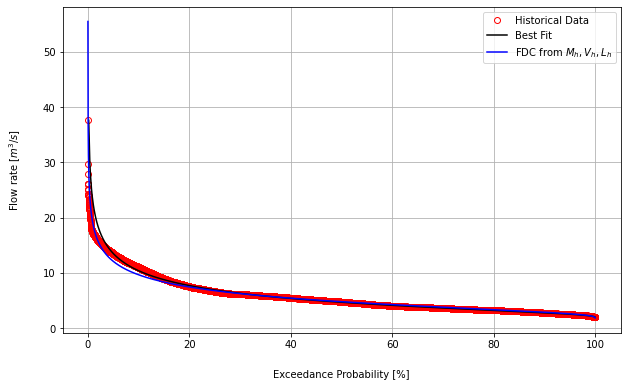

In [6]:
# Figure 1: plot historical FDC vs fitted curve and curve of multiplier of 1
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(fdc_probability*100, fdc_discharge,marker='o', markeredgecolor='r', linestyle='none', markerfacecolor='none', label="Historical Data")
plt.plot(p_pred*100, k_discharge,'k', label="Best Fit")
plt.plot(fdc_probability*100, m1_discharge,'b', label="FDC from $M_h, V_h, L_h$")
plt.legend(loc="upper right")
plt.xlabel("Exceedance Probability [%]", labelpad=20)
plt.ylabel("Flow rate [$m^3/s$]", labelpad=20)
plt.rc('font', size=20)
plt.grid() 

## Third Section: LHS Sampling for statistical pars: Median, CV, 1st percentile

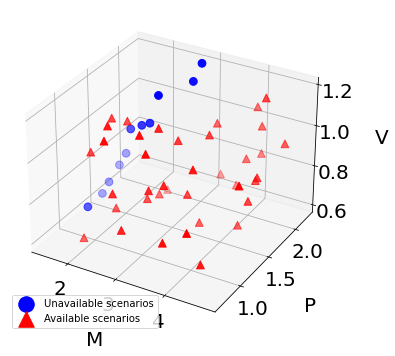

In [7]:
sampling = LHS(xlimits=xlimits)

# Use ranges and sampling to get multiplier for all three inputs
multiplier = sampling(num) 

M = multiplier[:, 0]*M1  #Median Sampling

V = multiplier[:, 1]*V1# Coefficient of variation (CV) Sampling

L = multiplier[:, 2]*L1 #First percntile Sampling

# find the scenarios in which sampled median is bigger than  sampled first percentile
if L1 > 0:
 diff = M / L 
 idx_s = np.where(diff > 1.3)  
else : 
 diff = M - L
 idx_s = np.where(diff > 0.1) 

idx = np.transpose(np.asarray(idx_s)) # get the index number of the available scenarios
av_num = len(idx); # find the number of available scenarios

#the unavailable scenarios
Mu = np.setdiff1d(M,  M[idx])
Vu = np.setdiff1d(V,  V[idx])
Lu = np.setdiff1d(L,  L[idx])


#select the available scenarios
M = M[idx]
V = V[idx]
L = L[idx]

#available set of multipliers
new_multip= multiplier[idx, :]
av_multiplier = np.reshape(new_multip, (av_num,3))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(Mu, Lu, Vu, marker='o', label='Unavailable scenarios', s=60., c='b');
ax.scatter3D(M, L, V, marker='^', label='Available scenarios', s=60., c='r');
ax.set_xlabel('M', labelpad=20)
ax.set_ylabel('L', labelpad=20)
ax.set_zlabel('V', labelpad=20)
plt.legend(loc="lower left", markerscale=2., scatterpoints=1, fontsize=10)
plt.rc('font', size=20)
plt.grid() 

## Fourth Section: Generate ensemble of future scenarios 

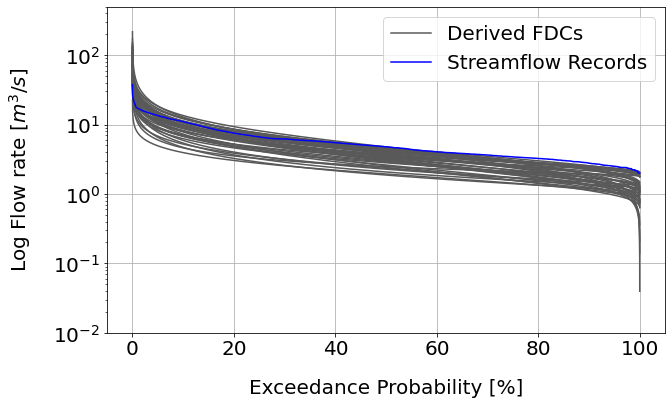

In [8]:
Nsize = np.size(fdc_probability) # find the size of the time series (input)
Q_futures = np.empty((Nsize,av_num)) # for future flows
Q_futures [:] = np.NaN
b = np.empty((av_num,1)) 
b [:] = np.NaN

#return exceedance probability of the originial sequence of the streamflow
os_probability = Return_OS(streamflow, fdc_probability);  
 
# Iterates over the scenarios to derive new FDC pars: a_s, b_s, c_s
for i in range(av_num):
  
 der_par = lambda par: Der_Opt( M[i], V[i], L[i], E, fdc_probability, Nsize, par)[0] #define the function to be optimized
 b[i] = scipy.optimize.fmin(func=der_par, x0=2, disp=False) # do the optimization
 
 Fdc_pars_future = Der_Opt( M[i], V[i], L[i], E, fdc_probability, Nsize, b[i])[1]
 Q_futures[:,i] = Kosugi(Fdc_pars_future, os_probability)
 Q_futures[:,i][Q_futures[:,i] < 0.01] = 0   
   
# Figure: derived FDCs
for j in range(av_num):
    s_fdc = Calc_Fdc(Q_futures [:,j]);  # Derive FDC
    s_probability = s_fdc[1] #Define the exceedance probability
    s_discharge = s_fdc[0] #Define the streamflow
    plt.plot(s_probability*100, s_discharge, c='0.35')
    plt.yscale("log")
    if j == av_num-1:
        l_fdc = Calc_Fdc(Q_futures[:,av_num-1]);  # Derive FDC
        plt.plot(l_fdc[1]*100, l_fdc[0], label="Derived FDCs",c='0.35')
        plt.plot(fdc_probability*100, fdc_discharge,'b', label="Streamflow Records")
        plt.legend(loc="upper right")
        plt.xlabel("Exceedance Probability [%]", labelpad=20)
        plt.ylabel("Log Flow rate [$m^3/s$]", labelpad=20)
        plt.rcParams["figure.figsize"] = (6,3)
        plt.rc('font', size=20)
        plt.grid() 
        plt.ylim(0.01, 500)

## Post Processor

In [9]:
num = av_num

# Derive streamflow statistics
Q_m, Q_v, Q_low = streamflow_statistics(Q_futures, low_percentile, num, case_to_derive)


Text(0, 0.5, 'M')

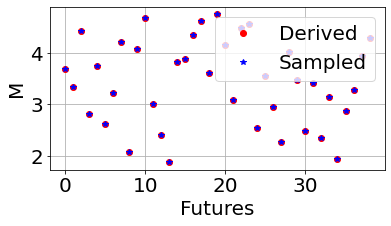

In [10]:
# Figure 3: plot sampled vs calculated mean/median values
plt.plot(Q_m, 'ro', label="Derived")
plt.plot(M, 'b*', label="Sampled")
plt.legend(loc="upper right")
plt.grid() 
plt.xlabel("Futures")
plt.ylabel("M")

Text(0, 0.5, 'V')

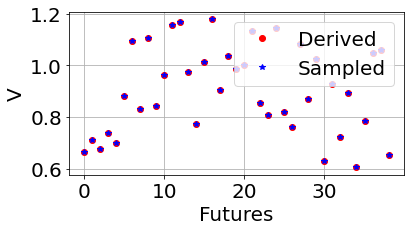

In [11]:
# Figure 4: plot sampled vs calculated Std/CV values
plt.plot(Q_v, 'ro', label="Derived")
plt.plot(V, 'b*', label="Sampled")
plt.legend(loc="upper right")
plt.grid()
plt.xlabel("Futures")
plt.ylabel("V")

Text(0, 0.5, 'Low Percentile [$m^3/s$]')

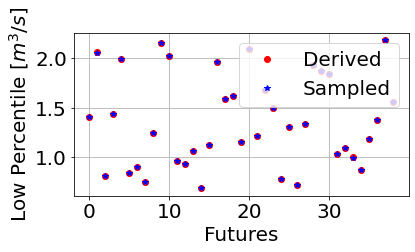

In [12]:
# Figure 5: plot sampled vs calculated low percentile values
plt.plot(Q_low, 'ro', label="Derived")
plt.plot(L, 'b*', label="Sampled")
plt.legend(loc="upper right")
plt.grid() 
plt.xlabel("Futures")
plt.ylabel("Low Percentile [$m^3/s$]")

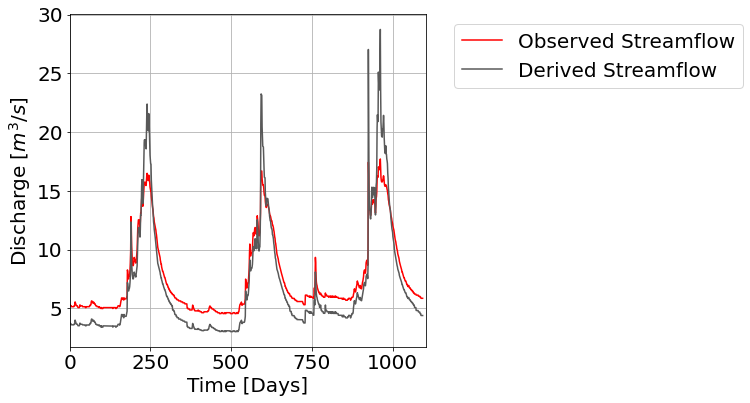

In [13]:
#Figure 6: Random 3 years of observed stream flow vs derived streamflow
plt.figure(figsize=(11, 6))
idplot = np.where((av_multiplier[:,1] > 1.75)  & (av_multiplier[:,0] < 0.75) & (0.5 < av_multiplier[:,0]) ) # find the scenario to plot
idplot = np.asarray(idplot) # converting tuple into int array 
if np.size(idplot) == 0:
       idplot = np.where(av_multiplier[:,1] >= 1.75)
       idplot = np.asarray(idplot) # converting tuple into int array 
idplot = np.min(idplot) # get on of the indices if there is more than one
   
qplot = Q_futures[:,idplot] # select the future 
qplot = np.reshape(qplot, (len(os_probability),1)) 
plt.plot(streamflow[8765:-1],'r', label="Observed Streamflow")
plt.plot(qplot[8765:-1], label="Derived Streamflow",c='0.35')
plt.legend(loc="upper right")
plt.xlabel("Time [Days]")
plt.ylabel("Discharge [$m^3/s$]")
plt.grid() 
plt.xlim(0, len(qplot[8765:-1])+10)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()